**Exploring NSL-KDD dataset**

The goal of this notebook is to provide a basic investigation of the NSL-KDD dataset. The following are the objectives of this investigation:

* Learn the fundamentals of the data set.
* Consider how the data set could be utilized to forecast network anomalies or attacks.
* Take a look at some fundamental concepts for developing machine learning models.

Throughout, I'll do some manual labor that could be done more efficiently with sci-kit's provided capabilities. The idea here is to be more deliberate in comprehending what we're doing and why we're doing it.


In [1]:
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

**Data extraction**

I'll begin by retrieving our data set. There are a few data set options here, so I'll create a couple paths and utilize comments to pick and choose which ones we want.

In [2]:
# fetch the training file
file_path_20_percent = '../input/nslkdd/KDDTrain+_20Percent.txt'
file_path_full_training_set = '../input/nslkdd/KDDTrain+.txt'
file_path_test = '../input/nslkdd/KDDTest+.txt' 

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [3]:
#data set doesn't include column names, so we need to add them.
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


**Data transformations** 

The initial transformations I'll want to perform revolve around the attack field. To begin, I'll create a column that encodes ***'normal'*** values as **0** and any other value as **1**. This will be our classifier in a basic binary model that identifies any attack.

In [4]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


Next, I'll classify each of the attacks according to attack type for a more granular prediction model.

**Denial of Service attacks:**
* apache2
* back
* land
* neptune
* mailbomb
* pod
* processtable
* smurf
* teardrop
* udpstorm
* worm

**Probe attacks:**
* ipsweep
* mscan
* nmap
* portsweep
* saint
* satan
* Privilege escalation attacks
* buffer_overflow
* loadmdoule
* perl
* ps
* rootkit
* sqlattack
* xterm

**Remote access attacks:**
* ftp_write
* guess_passwd
* http_tunnel
* imap
* multihop
* named
* phf
* sendmail
* snmpgetattack
* snmpguess
* spy
* warezclient
* warezmaster
* xclock
* xsnoop

In [5]:
# lists to hold the attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# I will use these for plotting below
attack_labels = ['Normal','DoS','Probe','U2R','Sybil']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks map to 2
        attack_type = 2
    elif attack in U2R:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in Sybil:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


**Data profiling**

Some preliminary inquiries on what we have in the set. The first is a simple attack table by protocol. A protocol in network traffic analysis is a simple technique for creating some first buckets to categorize our data. At this stage, ***'normal'*** is left in the set as a reference.

In [6]:
# attack vs protocol
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


This demonstrates that the majority of attacks will target a single protocol. There are various cross-protocol assaults (satan, nmap, ipsweep). Consider why this is the case: what is the objective of those attacks, and why would they be cross-protocol?

Also, notice how icmp data is less common in typical traffic.

**Visual Representation of Dataset**

Now I will look at some graphs to see how things are organized.

In [7]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   

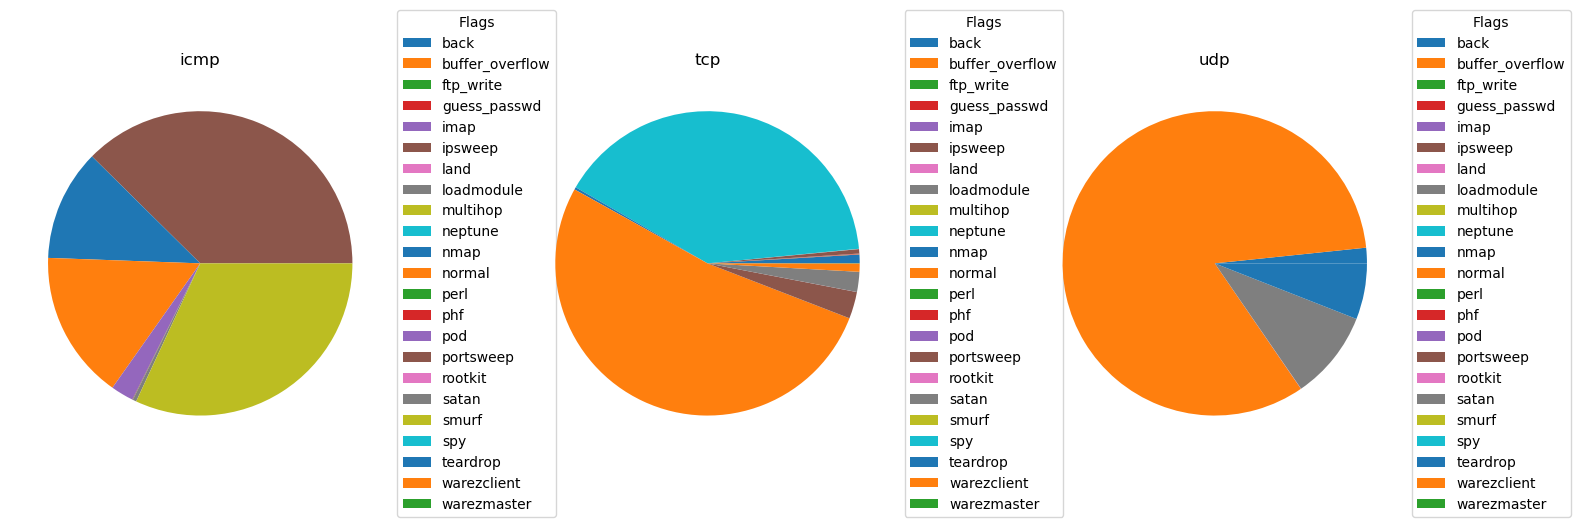

In [8]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# creating the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

The distinction between each protocol type should be noted here.The first view is that protocol may be beneficial in identifying the type of communication I am seeing. Now I will test whether flag behaves similarly.

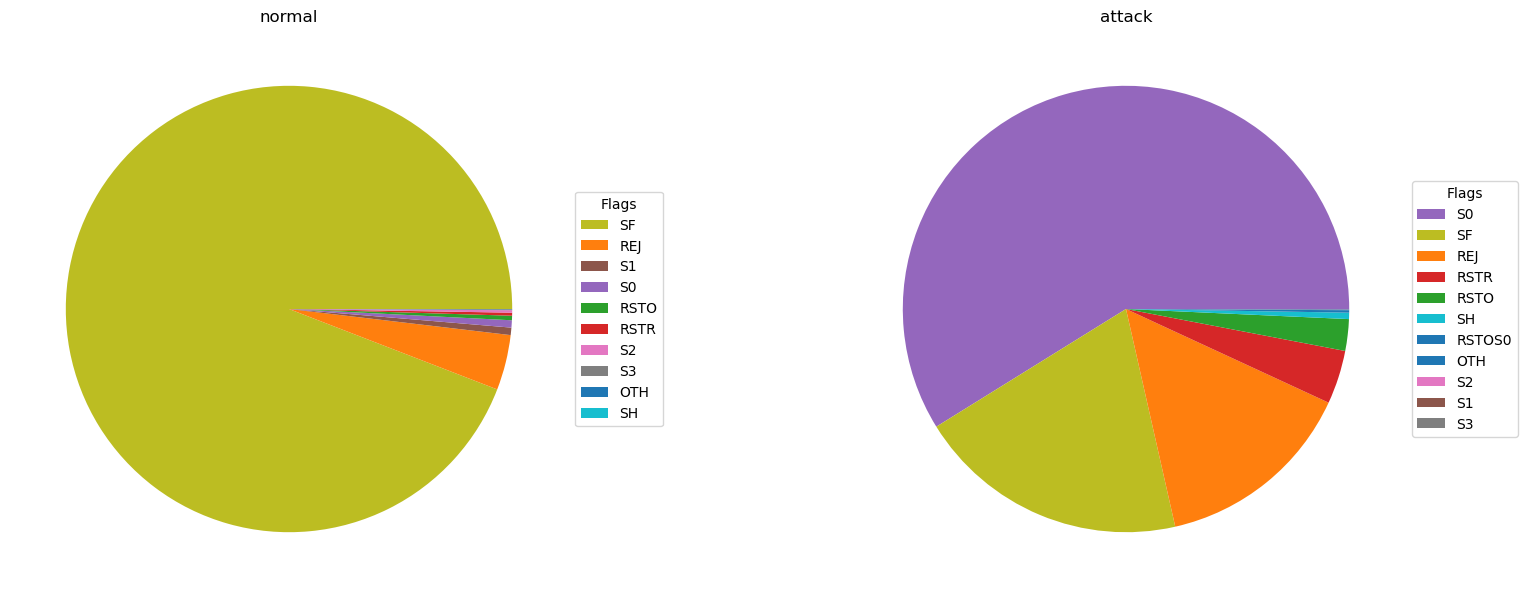

In [9]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# creating the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

What about Service?

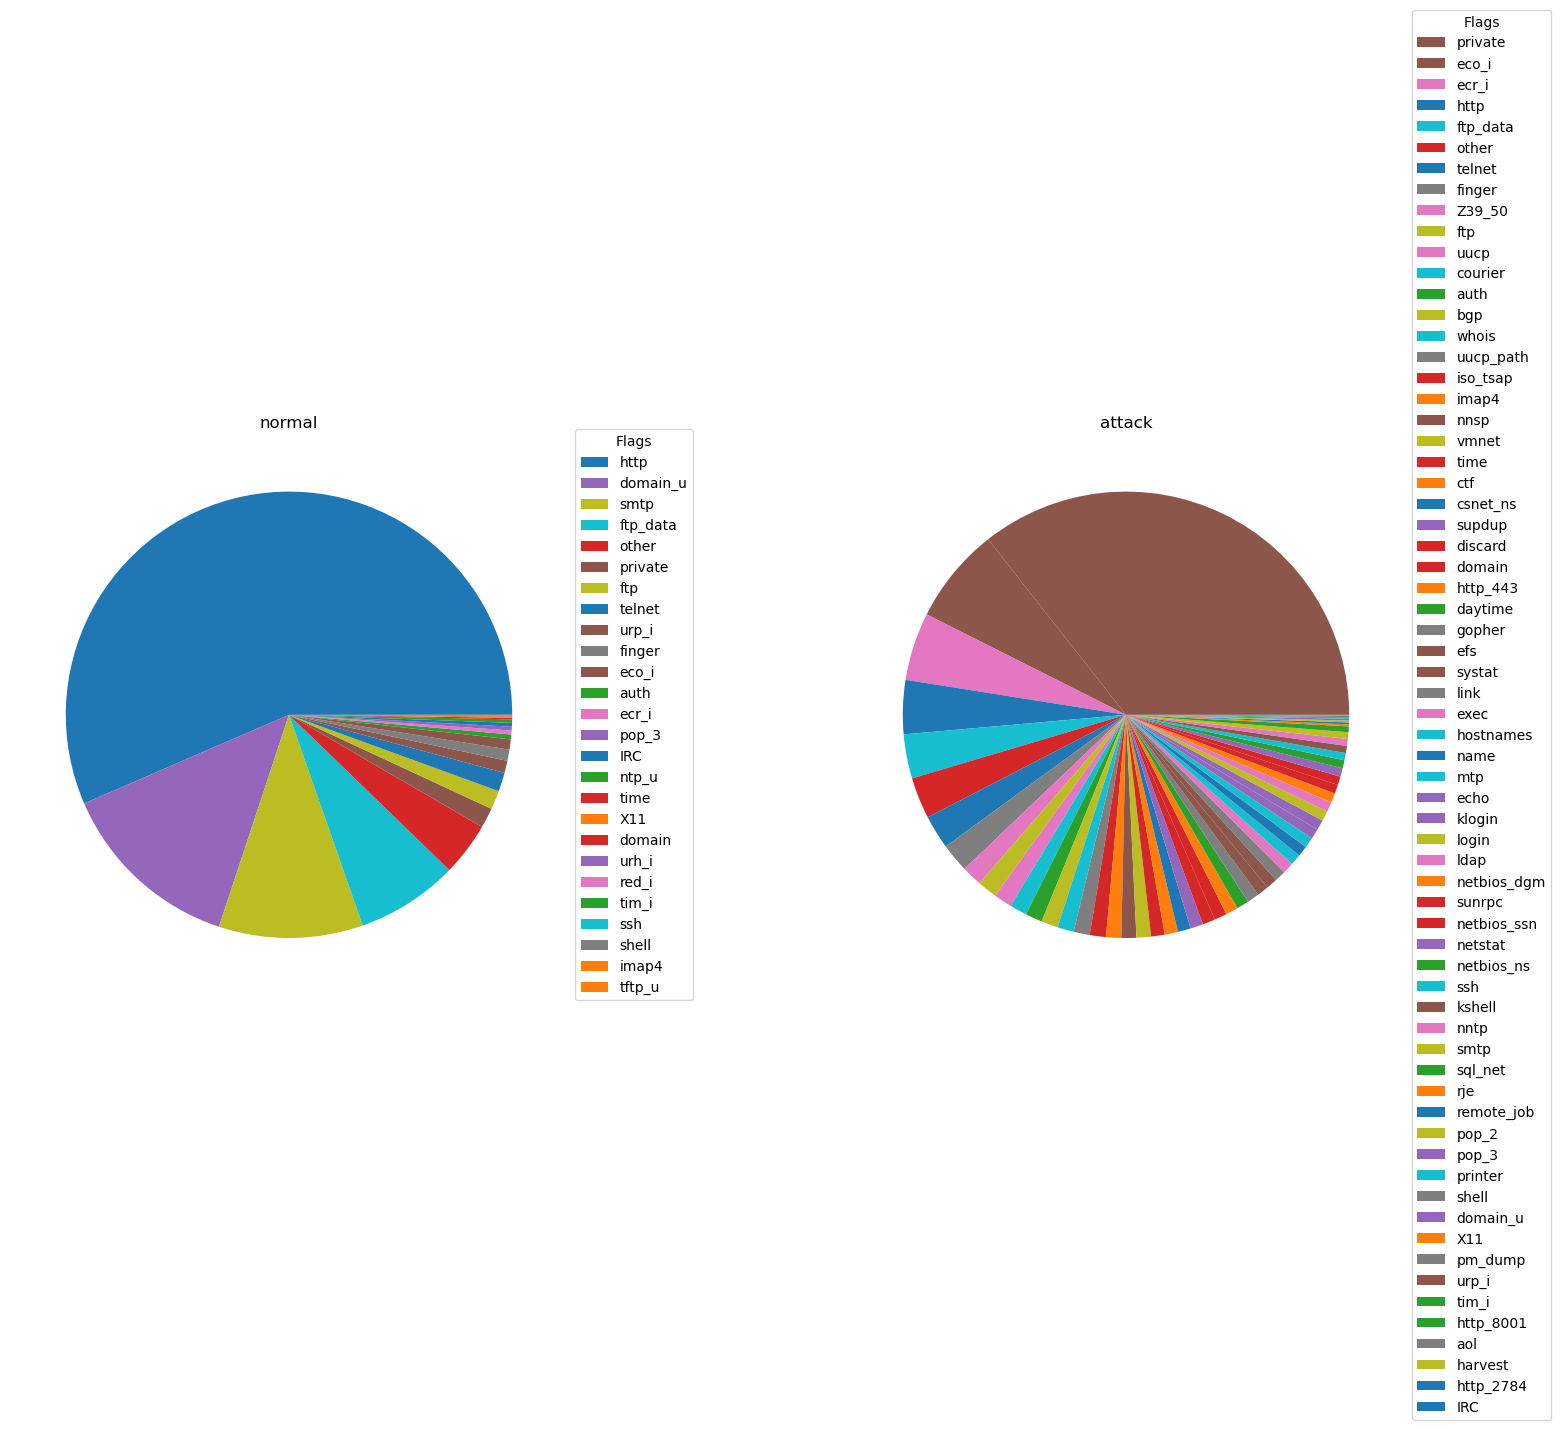

In [10]:
# get a series with the count of each service for attack and normal traffic
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])        
plt.show()

Consider how many services are included in the attack set! Whereas HTTP accounts for a large portion of typical traffic, our attack traffic is dispersed. That is interesting because it implies that assaults are looking for a variety of entry points into systems, some well traveled and some not.

From the perspective of a network administrator, the combination of protocol, flag, and service appears to tell me a lot about the nature of the traffic. Combining these with the time and amount of data in a connection appears to be a solid starting point for me.

**Feature Engineering**

So now I will get started on some feature development. The items listed above appear to be a decent place to start: protocol_type, service, and flag. There is enough variety amongst these that I should be able to identify them at a basic level. I'll also include some basic numerical data: duration, src_bytes, and dst_bytes. All of these will be readily available from current network equipment and should provide me with a wealth of information about what is happening on the network.

In [11]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so I need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# I'll also need to reorder the columns to match
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

It's important emphasizing a couple points here. To begin, pd.get_dummies is a method that allows me to quickly perform one-hot encoding on the columns. This takes every value found in a single column and creates a separate column for each value, with a **0** or **1** indicating whether the column is **'hot'**.

One thing I discovered is that every value is present in the test data. As a result, the data frame takes on many shapes. As a result, I created several columns, filled them in, and reorganized them. I know they're all zeros because the data doesn't show them.

Setting the classification goals. To begin, I'll use both binary and multi categorization training sets.

In [12]:
# create the target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

**Model fitting**

Decision trees are an excellent starting point for developing prediction models based on the nature of the data. In this scenario, I'll build and mix numerous trees using a random forest.

In [13]:
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display the base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9931731583403896

I got 99% accuracy on my first try. Time to see how this plays out.

It could be interesting to observe how other models compare to this data set. That is simple enough to accomplish with **cross_val_score**.

In [14]:
# define the list of models that I want to test
models = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=250),
    KNeighborsClassifier(),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate the list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

<AxesSubplot:>

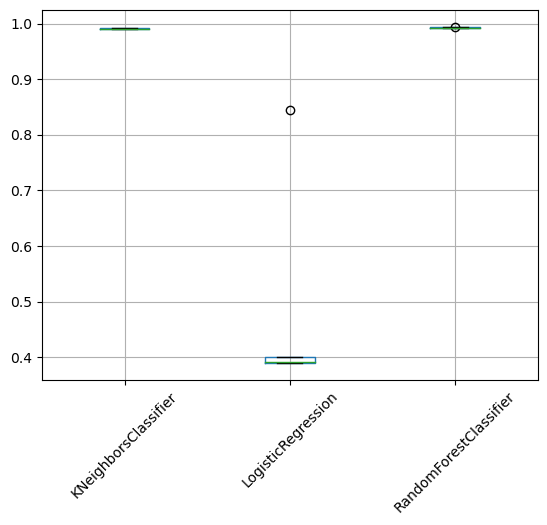

In [15]:
# A box plot will suffice to demonstrate overall performance and model variation.

result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

I discovered some disagreement among the models. The random forest and K-nearest neighbors are close-knit groups that function well. My logistic regression performed poorly. That could be because I didn't do enough preprocessing on our data to mould it into a form that was optimum for that model. Maybe I will tackle this at another time, but for now moving forward

**Time to Analyze the predictions**

So how did the forecasts perform? I'll write a helper function to extract some key metrics from the results.

In [16]:
# a helper function for getting some analytical data about the predictions
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # I need to add the predicted and actual outcomes to the data
    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    
    return prediction_data

I can now examine our results more closely. The first thing I can do is look at a confusion matrix, which will map the expected classification to the actual classification in this situation.

<AxesSubplot:>

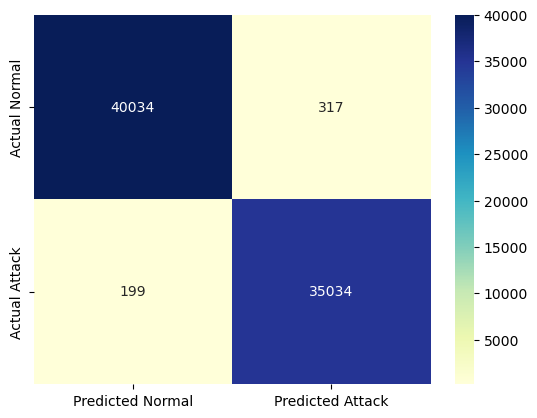

In [17]:
# capture the prediction data
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

There are many false positives (regular traffic identified as an attack) and false negatives (attack traffic flagged as normal) there.

So I am going to continue to dig a little more into the prediction mistakes to see if there's anything else I can learn. For now I will leave it here.